# Prepare street names for classification
In diesem Notebook werden die Daten des [Amtliches Verzeichnis der Strassen](https://www.cadastre.ch/de/services/service/registry/street.html) für das Matching mit weiteren Datenquellen aufbereitet.

## Load Dataset
Load dataset "official list of streets" of Switzerland

In [1]:
#Load all needed libraries
import urllib.request
from zipfile import ZipFile
import chardet
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Javascript
import numpy as np

In [2]:
url = 'https://data.geo.admin.ch/ch.swisstopo.amtliches-strassenverzeichnis/csv/2056/ch.swisstopo.amtliches-strassenverzeichnis.zip'
filehandle, _ = urllib.request.urlretrieve(url)

with ZipFile(filehandle, 'r') as zip:
    #zip.printdir()
    data = zip.read("pure_str.csv")
    
result = chardet.detect(data)
print(result)
print(type(data))

daten = StringIO(str(data,'UTF-8-SIG'))

streetnames = pd.read_csv(daten, encoding='UTF-8-SIG', sep=';')
streetnames.head()  


{'encoding': 'UTF-8-SIG', 'confidence': 1.0, 'language': ''}
<class 'bytes'>


,STR_ESID,STN_LABEL,ZIP_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_TYPE,STR_STATUS,STR_OFFICIAL,STR_VALID,STR_MODIFIED,STR_EASTING,STR_NORTHING
0,10258316,Eggwald,6484 Wassen UR,1220,Wassen,UR,Place,real,True,False,10.09.2022,NaN,NaN
1,10023770,Wiedenweg,4203 Grellingen,2786,Grellingen,BL,Street,real,True,True,09.09.2022,2610733.0,1254311.0
2,10179192,Wuhrbärgli,4253 Liesberg,2788,Liesberg,BL,Street,real,True,True,26.08.2022,2598709.0,1249640.0
3,10250501,Hüethütte Unter Trübsee,6390 Engelberg,1511,Wolfenschiessen,NW,Area,real,True,True,07.08.2021,2671798.0,1184817.0
4,10163108,Heimstenstich,4436 Liedertswil,2890,Liedertswil,BL,Area,real,True,True,14.10.2022,2621856.0,1248672.0


## Clean Dataset

Keep only streets (remove areas and places)
Total streetnames = 221'253 
Only with STR_TYPE = Street = 171'966 

In [3]:
streetnames = streetnames[streetnames.STR_TYPE == 'Street']

Check for missing data & remove 108 missing values in STR_EASTING & STR_NORTHING

In [4]:
missing_data = pd.DataFrame(
    streetnames.isnull().sum(),
    columns=['Missing Values'])

print(missing_data)

streetnames = streetnames.dropna()

              Missing Values
STR_ESID                   0
STN_LABEL                  0
ZIP_LABEL                  0
COM_FOSNR                  0
COM_NAME                   0
COM_CANTON                 0
STR_TYPE                   0
STR_STATUS                 0
STR_OFFICIAL               0
STR_VALID                  0
STR_MODIFIED               0
STR_EASTING              108
STR_NORTHING             108


    Check data types to streetname dataset

In [5]:
data_types = pd.DataFrame(
    streetnames.dtypes,
    columns=['Data Type'])

print(data_types)

             Data Type
STR_ESID         int64
STN_LABEL       object
ZIP_LABEL       object
COM_FOSNR        int64
COM_NAME        object
COM_CANTON      object
STR_TYPE        object
STR_STATUS      object
STR_OFFICIAL      bool
STR_VALID         bool
STR_MODIFIED    object
STR_EASTING    float64
STR_NORTHING   float64


Check if the values are unique and analyze values in columns

In [6]:
unique_values = pd.DataFrame(
    columns=['Unique Values'])
      
for row in list(streetnames.columns.values):
    unique_values.loc[row] = [streetnames[row].nunique()]
    
print(unique_values)

streetnames.groupby('STR_VALID').size()
   

              Unique Values
STR_ESID             171872
STN_LABEL             96373
ZIP_LABEL              6465
COM_FOSNR              2082
COM_NAME               2082
COM_CANTON               26
STR_TYPE                  1
STR_STATUS                2
STR_OFFICIAL              2
STR_VALID                 2
STR_MODIFIED            159
STR_EASTING          122669
STR_NORTHING         101887


STR_VALID
False      4706
True     167166
dtype: int64

Remove columns that are no longer needed.

Removed information:
STR_VALID == False: 4705 /
STR_STATUS == planned: 183 /
STR_OFFICIAL == False: 537 /
STR_TYPE: all Street /
COM_FOSNR: No analysis per ZIP planned /
STR_MODIFIED: All recently modified (oldest in 2021)

In [7]:
streetnames = streetnames.drop (['STR_TYPE', 'STR_VALID', 'STR_STATUS', 'ZIP_LABEL', 'STR_MODIFIED'], axis=1)

## Remove street terms 

Most common street names

In [8]:
most_common = streetnames.groupby("STN_LABEL").count()
most_common.COM_FOSNR.nlargest(10)

STN_LABEL
Dorfstrasse         637
Bahnhofstrasse      518
Hauptstrasse        484
Birkenweg           321
Kirchweg            313
Schulstrasse        293
Oberdorfstrasse     268
Industriestrasse    259
Schulhausstrasse    244
Rosenweg            243
Name: COM_FOSNR, dtype: int64

Count and visualize steet terms (not case sensitive)
DE: 'wegli', 'strasse', 'weg', 'platz', 'gasse', 'gässli', 'wäg',
FR: 'avenue ', 'ave. ', 'boulevard ', 'chemin ', 'impasse ', 'place', 'route ', 'rue ', 'ruelle ', 
IT: 'piazza ', 'via ', 'viale '

Important: Add spaces to words that are often string within other words (You can test ist with 'rue' vs 'rue '

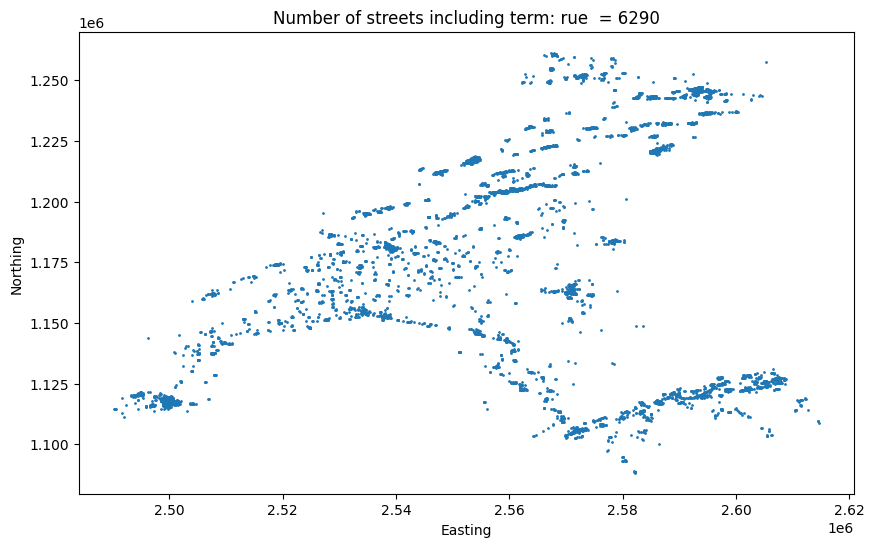

In [9]:
searchString = "rue "
searchStringStrassen = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString, case=False)]
count = len(searchStringStrassen)
count = "Number of streets including term: "+ searchString + " = "+  str(count)

fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(x=searchStringStrassen['STR_EASTING'], y=searchStringStrassen['STR_NORTHING'], s = 1)
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title(count)
plt.show()

Delete spaces at the beginning and end of the string using function 'strip()'

In [10]:
#Create new Column (so we can always compare with original values)
streetnames ['STN_LABEL_NO_BI'] = streetnames.loc[:, 'STN_LABEL']

streetnames['STN_LABEL_NO_BI'] = streetnames['STN_LABEL_NO_BI'].str.strip()

Delete everything (in string) after bracket and slash. We do this mainly to keep only the first language in bilingual names.

In [11]:
streetnames['STN_LABEL_NO_BI'] = streetnames['STN_LABEL_NO_BI'].str.replace("(/).*","", regex=True)
streetnames['STN_LABEL_NO_BI'] = streetnames['STN_LABEL_NO_BI'].str.replace("(\().*","", regex=True)

#Delete spaces at the beginning and end of the string using function 'strip()'
streetnames['STN_LABEL_NO_BI'] = streetnames['STN_LABEL_NO_BI'].str.strip()

#Check if it worked
streetnames[streetnames["STN_LABEL_NO_BI"].str.contains("Chandosselweg|Figgione")].head()

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_OFFICIAL,STR_EASTING,STR_NORTHING,STN_LABEL_NO_BI
746,10022105,Chandosselweg / Chemin de Chandossel,2250,Courgevaux,FR,True,2574274.0,1194118.0,Chandosselweg
220129,10244635,Figgione (nucleo),5072,Faido,TI,True,2706220.0,1148322.0,Figgione


Duplicate column of street names

In [12]:
streetnames ['STN_LABEL_NO_TERMS'] = streetnames.loc[:, 'STN_LABEL_NO_BI']

Move (to new column) and replace street terms

Important: Add spaces to words that are often string within other words (e.g. 'rue' vs 'rue ')
Always substring afterwards: 'wegli' before 'weg' 

In [13]:
terms = ('strasse',  'wegli','platz', 'gasse', 'gässli', 'wäg', 'strässli', 
'avenue ', 'boulevard ', 'chemin ', 'impasse ', 'place ', 'route', 'ruelle ', 'rue ', 
'sentier ', 'passage ', 'promenade ', 'quai',
'piazza ', 'viale ', 
'strada ', 'veia ', 'vietta ', 'gassa ', 'voia ','voa')

terms2 = ('weg', 'via ')
    
for i in terms2:
    streetnames.loc[streetnames.STN_LABEL.str.contains(i,case=False), 'STR_TERMS'] = i
        
for i in terms:
    streetnames.loc[streetnames.STN_LABEL.str.contains(i,case=False), 'STR_TERMS'] = i
    streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.replace(i, '',case=False, regex=True)

for i in terms2:
    streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.replace(i, '',case=False, regex=True)
    
#Delete spaces at the beginning and end of the string using function 'strip()'
streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.strip()
streetnames['STR_TERMS'] = streetnames['STR_TERMS'].str.strip()

In [14]:
streetnames.groupby('STR_TERMS',dropna=False).size()

STR_TERMS
avenue         708
boulevard       32
chemin       15021
gassa           47
gasse         3761
gässli        1008
impasse       1147
passage        274
piazza          42
place          168
platz          615
promenade      130
quai           166
route         6822
rue           6286
ruelle         703
sentier        390
strada         316
strasse      49112
strässli        15
veia           157
via           6784
viale           51
vietta          26
voa             59
voia            49
weg          43119
wegli          229
wäg            236
NaN          34399
dtype: int64

In [15]:
streetnames.head()

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_OFFICIAL,STR_EASTING,STR_NORTHING,STN_LABEL_NO_BI,STN_LABEL_NO_TERMS,STR_TERMS
1,10023770,Wiedenweg,2786,Grellingen,BL,True,2610733.0,1254311.0,Wiedenweg,Wieden,weg
2,10179192,Wuhrbärgli,2788,Liesberg,BL,True,2598709.0,1249640.0,Wuhrbärgli,Wuhrbärgli,NaN
9,10140563,Emanuelenweg,2829,Liestal,BL,True,2623078.0,1257558.0,Emanuelenweg,Emanuelen,weg
13,10069457,Löhrweg,2850,Känerkinden,BL,True,2630229.0,1251411.0,Löhrweg,Löhr,weg
15,10096235,Brunngasse,2833,Seltisberg,BL,True,2621406.0,1256852.0,Brunngasse,Brunn,gasse


## Remove prepositions, stopwords and special characters

First replace special caracters and punctuation marks

In [16]:
special = (['.', ' '],[',', ' '],[';', ' '],[':', ' '],['-', ' '],['\'', ' '],[',', ' '],[' ', ' '],
['è', 'e'],['é', 'e'],['ê', 'e'],['ë', 'e'],['à', 'a'],['á', 'a'],['â', 'a'],['ô', 'o'],['ò', 'o'],['ó', 'o'],
['û', 'u'],['ù', 'u'],['ú', 'u'],['ï', 'i'],['í', 'i'],['î', 'i'],['ç', 'c'])
# Not useful for matching with wikidata,['ä', 'ae'],['ü', 'ue'],['ö', 'oe']        )

for i in special:
    streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.replace(i[0],i[1],case=False, regex=True)
    
#Delete spaces at the beginning and end of the string using function 'strip()'
streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.strip()

Then move (to new column) and replace designations

For the cases with more than one designation we only keep the last designation in the dictionary.

In [17]:
terms = (['hinterer ', 'hinter'],['hinteren ', 'hinter'],['hinteres ', 'hinter'],['hintere ', 'hinter'],['hinter ', 'hinter'],
['oberen ', 'ober'],['oberer ', 'ober'],['oberes ', 'ober'],['obere ', 'ober'],['ober ', 'ober'],['oberi ', 'ober'],
['vorderen ', 'vorder'],['vorderer ', 'vorder'],['vorderes ', 'vorder'],['vordere ', 'vorder'],['vorder ', 'vorder'],
['unteren ', 'unter'],['unterer ', 'unter'],['unteres ', 'unter'],['untere ', 'unter'],['unter ', 'unter'],['sous ', 'unter'],['unterem ', 'unter'],['unterm ', 'unter'],
['mittleren ', 'mittler'],['mittlerer ', 'mittler'],['mittleres ', 'mittler'],['mittlere ', 'mittler'],['mittler ', 'mittler'],
['äusseren ', 'äusser'],['äusserer ', 'äusser'],['äusseres ', 'äusser'],['äussere ', 'äusser'],['äusser ', 'äusser'],
['inneren ', 'inner'],['innerer ', 'inner'],['inneres ', 'inner'],['innere ', 'inner'],['inner ', 'inner'],
['kleines ', 'klein'],['kleiner ', 'klein'],['kleinen ', 'klein'],['kleine ', 'klein'],['klein ', 'klein'],['petite ', 'klein'],['petit ', 'klein'],
['grosses ', 'gross'],['grosser ', 'gross'],['grossen ', 'gross'],['grosse ', 'gross'],['gross ', 'gross'],['grand ', 'gross'],['grande ', 'gross'],
['san ', 'sankt'],['santa ', 'sankt'],['sankt ', 'sankt'],['saint ', 'sankt'],['sainte ', 'sankt'],['st ', 'sankt'],['ste ', 'sankt'],
['ancien ', 'alt'],['ancienne ', 'alt'],['alte ', 'alt'],['alter ', 'alt'],['altes ', 'alt'],['alten ', 'alt'],
['mont ', 'mont'])

for i in terms:
    streetnames.loc[streetnames.STN_LABEL_NO_TERMS.str.contains(i[0],case=False), 'STR_PREPS'] = i[1]
    streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.replace(i[0],'',case=False, regex=True)
    
#Delete spaces at the beginning and end of the string using function 'strip()'
streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.strip()
streetnames['STR_PREPS'] = streetnames['STR_PREPS'].str.strip()

In [18]:
streetnames[streetnames["STN_LABEL"].str.contains('Wolfgalgenstutz')].head()

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_OFFICIAL,STR_EASTING,STR_NORTHING,STN_LABEL_NO_BI,STN_LABEL_NO_TERMS,STR_TERMS,STR_PREPS
33,10142028,Wolfgalgenstutz,2851,Kilchberg (BL),BL,True,2634691.0,1252654.0,Wolfgalgenstutz,Wolfgalgenstutz,NaN,NaN


In [19]:
streetnames.groupby('STR_PREPS',dropna=False).size()

STR_PREPS
alt          1109
gross         453
hinter        332
inner          61
klein         266
mittler       167
mont          115
ober         1539
sankt        1025
unter        1562
vorder        192
äusser         61
NaN        164990
dtype: int64

Finally create final column (for matching with other datasets) and remove stopwords

In [20]:
streetnames ['STN_LABEL_FINAL'] = streetnames.loc[:, 'STN_LABEL_NO_TERMS']

In [21]:
stop = ('le' ,'la' , 'en' , 'au' , 'da' ,'im' , 'in' , 'ai' , 'al' ,
        'am' , 'l''','a'  ,'les', 'auf', 'aux', 'bei','der', 'die', 
        'das','zum', 'beim', 'de', 'des', 'du', 'd''', 'della', 'alla', 
        'di', 'delle', 'del', 'dei', 'den', 'dal', 'zur', 'vers',
        'Le' ,'La' , 'En' , 'Au' , 'Da' ,'Im' , 'In' , 'Ai' , 'Al' ,
        'Am' , 'L''','A'  ,'Les', 'Auf', 'Aux', 'Bei','Der', 'Die', 
        'Das','Zum', 'Beim', 'De', 'Des', 'Du', 'D''', 'Della', 'Alla', 
        'Di', 'Delle', 'Del', 'Dei', 'Den', 'Dal', 'Zur', 'Zers', 'sur', 'Sur')

#streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].str.lower().str.split(' ')
streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].str.split(' ')

streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].apply(lambda x: [item for item in x if item not in stop])

streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].str.join(' ')

#Delete spaces at the beginning and end of the string using function 'strip()'
streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].str.strip()

In [22]:
streetnames

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_OFFICIAL,STR_EASTING,STR_NORTHING,STN_LABEL_NO_BI,STN_LABEL_NO_TERMS,STR_TERMS,STR_PREPS,STN_LABEL_FINAL
1,10023770,Wiedenweg,2786,Grellingen,BL,True,2610733.0,1254311.0,Wiedenweg,Wieden,weg,NaN,Wieden
2,10179192,Wuhrbärgli,2788,Liesberg,BL,True,2598709.0,1249640.0,Wuhrbärgli,Wuhrbärgli,NaN,NaN,Wuhrbärgli
9,10140563,Emanuelenweg,2829,Liestal,BL,True,2623078.0,1257558.0,Emanuelenweg,Emanuelen,weg,NaN,Emanuelen
13,10069457,Löhrweg,2850,Känerkinden,BL,True,2630229.0,1251411.0,Löhrweg,Löhr,weg,NaN,Löhr
15,10096235,Brunngasse,2833,Seltisberg,BL,True,2621406.0,1256852.0,Brunngasse,Brunn,gasse,NaN,Brunn
...,...,...,...,...,...,...,...,...,...,...,...,...,...
221269,10107114,Tannenstrasse,4471,Bischofszell,TG,True,2736565.0,1261881.0,Tannenstrasse,Tannen,strasse,NaN,Tannen
221270,10070806,Rebenstrasse,4724,Eschlikon,TG,True,2716120.0,1258548.0,Rebenstrasse,Reben,strasse,NaN,Reben
221272,10142291,Fritz-Gegauf-Strasse,4864,Steckborn,TG,True,2715726.0,1280124.0,Fritz-Gegauf-Strasse,Fritz Gegauf,strasse,NaN,Fritz Gegauf
221274,10093237,Obere Bleichewiese,4571,Gachnang,TG,True,2705606.0,1266777.0,Obere Bleichewiese,Bleichewiese,NaN,ober,Bleichewiese


## Useful for optimization of designations and stop words

In [29]:
most_common = streetnames.groupby("STN_LABEL_FINAL").count()
most_common.COM_FOSNR.nlargest(50)

STN_LABEL_FINAL
Dorf          904
Kirch         760
Bahnhof       703
Schul         573
Haupt         518
Oberdorf      481
Halden        462
              415
Bach          413
Garten        409
Birken        405
Linden        376
Mühle         374
Feld          371
Berg          369
Schulhaus     362
Post          352
Moos          351
Industrie     338
Rosen         335
Weid          317
Rain          316
Unterdorf     309
Matten        298
Rüti          298
Winkel        284
Höhen         279
Baumgarten    268
Erlen         260
Wiesen        260
Jura          256
Allmend       242
Blumen        237
Ahorn         228
Ring          222
Gare          220
Buchen        219
Eglise        210
Schützen      202
Hof           200
Friedhof      199
Sonnen        199
Grund         198
See           194
Weiher        194
Bahn          191
Schloss       185
Burg          182
Büel          180
Damm          177
Name: COM_FOSNR, dtype: int64

In [51]:
#Example: filter all special street designations with ' ' (more than one word)

test = streetnames.STN_LABEL_FINAL.dropna()
filter2 = test.loc[test.str.contains('bach', case=False, regex=True)]

with pd.option_context("display.max_rows", 20000):
    display(filter2)

count = len(filter2)
count = "Number of streets including term: "+  str(count)
print(count)

173                                               Bach
229                                               Bach
407                                               Bach
498                                           Dorfbach
1410                                           Grabach
1991                                           Sodbach
1999                                         Bachgassa
2218                                              Bach
2558                                         Mühlebach
2567                                      Jean Gambach
2764                                     Bachpromenade
3151                                          Bachmatt
3925                                       Arieschbach
4021                                         Unterbach
4053                                         Chronbach
4126                                              Bach
4136                                           Hofbach
4216                                         Sägenbach
4233      

Number of streets including term: 2752


In [40]:
#Example2: filter all special street designations with 'Rue' but not 'Rue.'

filter2 = streetnames.loc[(streetnames.STN_LABEL_FINAL.str.contains("kirch")) & 
                          (~streetnames.STN_LABEL_FINAL.str.contains("kirch.", regex=True))]

with pd.option_context("display.max_rows", 20000):
    display(filter2)

count = len(filter2)
count = "Number of streets including term: "+  str(count)
print(count)

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_OFFICIAL,STR_EASTING,STR_NORTHING,STN_LABEL_NO_BI,STN_LABEL_NO_TERMS,STR_TERMS,STR_PREPS,STN_LABEL_FINAL
217,10128941,Hinterkirchweg,2775,Therwil,BL,True,2608730.0,1260798.0,Hinterkirchweg,Hinterkirch,weg,NaN,Hinterkirch
8082,10097726,Neukirch,3672,Safiental,GR,True,2744562.0,1175543.0,Neukirch,Neukirch,NaN,NaN,Neukirch
28603,10190876,Hinterkirchweg,2773,Reinach (BL),BL,True,2611742.0,1260080.0,Hinterkirchweg,Hinterkirch,weg,NaN,Hinterkirch
56512,10094224,Mittskirchstrasse,4324,Zurzach,AG,True,2664573.0,1271106.0,Mittskirchstrasse,Mittskirch,strasse,NaN,Mittskirch
59293,10105280,Meikirchstrasse,360,Wohlen bei Bern,BE,True,2595095.0,1204579.0,Meikirchstrasse,Meikirch,strasse,NaN,Meikirch
62720,10058071,Meikirchstrasse,307,Meikirch,BE,True,2596924.0,1204920.0,Meikirchstrasse,Meikirch,strasse,NaN,Meikirch
92637,10028460,Mittskirchweg,4324,Zurzach,AG,True,2664546.0,1271188.0,Mittskirchweg,Mittskirch,weg,NaN,Mittskirch
99255,10189087,Obkirchweg,1068,Vitznau,LU,True,2679503.0,1207067.0,Obkirchweg,Obkirch,weg,NaN,Obkirch
99749,10083272,Neuenkirchstrasse,1098,Ruswil,LU,True,2652316.0,1215033.0,Neuenkirchstrasse,Neuenkirch,strasse,NaN,Neuenkirch
101444,10240995,Neuenkirchstrasse,1093,Neuenkirch,LU,True,2658413.0,1214468.0,Neuenkirchstrasse,Neuenkirch,strasse,NaN,Neuenkirch


Number of streets including term: 23


In [25]:
missing_data = pd.DataFrame(
    streetnames.isnull().sum(),
    columns=['Missing Values'])

print(missing_data)

                    Missing Values
STR_ESID                         0
STN_LABEL                        0
COM_FOSNR                        0
COM_NAME                         0
COM_CANTON                       0
STR_OFFICIAL                     0
STR_EASTING                      0
STR_NORTHING                     0
STN_LABEL_NO_BI                  0
STN_LABEL_NO_TERMS               0
STR_TERMS                    34399
STR_PREPS                   164990
STN_LABEL_FINAL                  0


Command to run all cells above

In [26]:
#from IPython.display import Javascript
#display(Javascript('IPython.notebook.execute_cells_above()'))

In [52]:
missing_data = pd.DataFrame(
    streetnames.isnull().sum(),
    columns=['Missing Values'])

print(missing_data)

                    Missing Values
STR_ESID                         0
STN_LABEL                        0
COM_FOSNR                        0
COM_NAME                         0
COM_CANTON                       0
STR_OFFICIAL                     0
STR_EASTING                      0
STR_NORTHING                     0
STN_LABEL_NO_BI                  0
STN_LABEL_NO_TERMS               0
STR_TERMS                    34399
STR_PREPS                   164990
STN_LABEL_FINAL                  0


In [28]:
streetnames.to_csv('C:\CAS_Arbeit\cassda-zertifikatsarbeit\Datapreparation\streetnames.csv', encoding='UTF-8-SIG', sep=';')